In [1]:
import pandas as pd
from typing import List, Dict, Optional

def load_loss_intervals_with_gap(
        csv_path: str,
        max_batch_idx: int = 13,
        gap_threshold: int = 6
    ) -> List[Dict[int, Optional[float]]]:
    """
    讀取 loss_log.csv，當「下一筆 batch_idx 與前一筆 batch_idx 的差值」> gap_threshold
    時視為跨區間，將資料切割成多個區間清單。

    每個區間以 {batch_idx: total_loss, …} 形式呈現；
    若該區間缺少某些 batch_idx，則以 None 補位。

    Parameters
    ----------
    csv_path : str
        CSV 檔路徑
    max_batch_idx : int, default 13
        區間內保留的最大 batch_idx（如 1~13）
    gap_threshold : int, default 6
        判定跨區間的差值門檻

    Returns
    -------
    List[Dict[int, Optional[float]]]
        依序排列的區間清單
    """
    df = pd.read_csv(csv_path)

    intervals: List[Dict[int, Optional[float]]] = []
    current: Dict[int, Optional[float]] = {}
    prev_idx: Optional[int] = None

    for _, row in df.iterrows():
        idx  = int(row["batch_idx"])
        loss = float(row["total_loss"])

        # 只關注 1 ~ max_batch_idx
        if idx > max_batch_idx:
            continue

        # 若前後索引差值大於門檻，視為跨區間
        if prev_idx is not None and abs(idx - prev_idx) > gap_threshold:
            for i in range(1, max_batch_idx + 1):
                current.setdefault(i, None)   # 補齊缺失值
            intervals.append(current)
            current = {}

        # 收集當前批次的 total_loss
        current[idx] = loss
        prev_idx = idx

    # 收尾最後一段
    if current:
        for i in range(1, max_batch_idx + 1):
            current.setdefault(i, None)
        intervals.append(current)

    return intervals


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_analyze_loss_data(csv_path):
    """
    載入並分析損失數據的完整統計分析
    
    Args:
        csv_path (str): CSV 檔案路徑
        
    Returns:
        dict: 包含所有統計分析結果的字典
    """
    # 讀取 CSV 檔案
    df = pd.read_csv(csv_path)
    
    # 定義需要分析的損失欄位
    loss_columns = ["original_loss", "auxiliary_loss", "normalized_auxiliary_loss", "total_loss"]
    
    # 基本統計量計算
    basic_stats = {}
    for col in loss_columns:
        data = df[col].values
        basic_stats[col] = {
            "count": len(data),
            "mean": np.mean(data),
            "median": np.median(data),
            "std": np.std(data),
            "var": np.var(data),
            "min": np.min(data),
            "max": np.max(data),
            "range": np.max(data) - np.min(data),
            "q25": np.percentile(data, 25),
            "q75": np.percentile(data, 75),
            "iqr": np.percentile(data, 75) - np.percentile(data, 25),
            "skewness": skew(data),
            "kurtosis": kurtosis(data),
            "cv": np.std(data) / np.mean(data)  # 變異係數
        }
    
    # 相關性分析
    correlation_matrix = df[loss_columns].corr()
    
    # 異常值檢測 (3σ 法則)
    outliers = {}
    for col in loss_columns:
        data = df[col].values
        mean = np.mean(data)
        std = np.std(data)
        outlier_threshold = 3 * std
        outliers[col] = {
            "upper_bound": mean + outlier_threshold,
            "lower_bound": mean - outlier_threshold,
            "outlier_count": len(data[(data > mean + outlier_threshold) | (data < mean - outlier_threshold)]),
            "outlier_percentage": len(data[(data > mean + outlier_threshold) | (data < mean - outlier_threshold)]) / len(data) * 100
        }
    
    # 批次統計
    batch_stats = df.groupby('batch_idx')[loss_columns].agg(['mean', 'std', 'count'])
    
    # 時間序列分析
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    time_stats = {
        "duration": (df['timestamp'].max() - df['timestamp'].min()).total_seconds() / 3600,  # 小時
        "total_records": len(df),
        "avg_records_per_hour": len(df) / ((df['timestamp'].max() - df['timestamp'].min()).total_seconds() / 3600)
    }
    
    return {
        "basic_stats": basic_stats,
        "correlation_matrix": correlation_matrix,
        "outliers": outliers,
        "batch_stats": batch_stats,
        "time_stats": time_stats,
        "raw_data": df
    }

def print_analysis_results(analysis_results):
    """
    格式化輸出統計分析結果
    """
    print("=" * 60)
    print("LCP 損失訓練數據統計分析報告")
    print("=" * 60)
    
    # 基本統計量
    print("\n📊 基本統計量:")
    print("-" * 50)
    for loss_type, stats in analysis_results["basic_stats"].items():
        print(f"\n{loss_type.upper()}:")
        print(f"  平均值: {stats['mean']:.6f}")
        print(f"  中位數: {stats['median']:.6f}")
        print(f"  標準差: {stats['std']:.6f}")
        print(f"  最小值: {stats['min']:.6f}")
        print(f"  最大值: {stats['max']:.6f}")
        print(f"  偏度: {stats['skewness']:.3f}")
        print(f"  峰度: {stats['kurtosis']:.3f}")
        print(f"  變異係數: {stats['cv']:.3f}")
    
    # 相關性矩陣
    print("\n🔗 相關性矩陣:")
    print("-" * 50)
    print(analysis_results["correlation_matrix"].round(3))
    
    # 異常值檢測
    print("\n⚠️  異常值檢測 (3σ 法則):")
    print("-" * 50)
    for loss_type, outlier_info in analysis_results["outliers"].items():
        print(f"{loss_type}: {outlier_info['outlier_count']} 個異常值 ({outlier_info['outlier_percentage']:.2f}%)")
    
    # 時間統計
    print("\n⏱️  時間統計:")
    print("-" * 50)
    print(f"訓練總時長: {analysis_results['time_stats']['duration']:.2f} 小時")
    print(f"總記錄數: {analysis_results['time_stats']['total_records']}")
    print(f"平均每小時記錄數: {analysis_results['time_stats']['avg_records_per_hour']:.2f}")

In [3]:
def filter(datas, lower_bound=None, upper_bound=None, use_3sigma=True):
    """
    過濾資料中 value 為 None 或超出異常值範圍的項目
    
    Args:
        datas (list of dict): 要過濾的資料列表，每個元素為字典
        lower_bound (float): 自定義下界，低於此值視為異常
        upper_bound (float): 自定義上界，高於此值視為異常
        use_3sigma (bool): 是否使用 3σ 法則自動計算異常值界限
    
    Returns:
        list of dict: 過濾後的資料列表
    """
    import numpy as np
    
    # 如果啟用 3σ 法則，自動計算異常值界限
    if use_3sigma:
        all_values = []
        for data_dict in datas:
            for value in data_dict.values():
                if value is not None:
                    all_values.append(value)
        
        if all_values:
            mean = np.mean(all_values)
            std = np.std(all_values)
            calculated_lower = mean - 3 * std
            calculated_upper = mean + 3 * std
            
            # 使用計算出的界限（如果沒有自定義界限的話）
            if lower_bound is None:
                lower_bound = calculated_lower
            if upper_bound is None:
                upper_bound = calculated_upper
    
    filtered_datas = []
    stats = {
        'total_items': len(datas),
        'none_count': 0,
        'outlier_count': 0,
        'valid_count': 0
    }
    
    for i in datas:
        new_dict = {}
        for key, value in i.items():
            # 過濾 None 值
            if value is None:
                stats['none_count'] += 1
                continue
                
            # 過濾異常值
            is_outlier = False
            if lower_bound is not None and value < lower_bound:
                is_outlier = True
            if upper_bound is not None and value > upper_bound:
                is_outlier = True
                
            if is_outlier:
                stats['outlier_count'] += 1
                continue
                
            # 保留有效值
            new_dict[key] = value
            stats['valid_count'] += 1
        
        # 只保留非空的字典
        if new_dict:
            filtered_datas.append(new_dict)
    
    # 輸出統計信息
    print(f"過濾統計:")
    print(f"  原始區間數: {stats['total_items']}")
    print(f"  None 值數量: {stats['none_count']}")
    print(f"  異常值數量: {stats['outlier_count']}")
    print(f"  有效值數量: {stats['valid_count']}")
    if lower_bound is not None and upper_bound is not None:
        print(f"  異常值界限: [{lower_bound:.3f}, {upper_bound:.3f}]")
    
    return filtered_datas


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict

def fill_nan_dynamic(intervals: List[Dict[int, float]]) -> List[Dict[int, float]]:
    """
    針對每個區段字典，自動補上缺失的 batch_idx，
    並將缺失處以 np.nan 佔位，使 x 軸保持真實間距。
    """
    filled = []

    for block in intervals:
        if not block:                     # 避免空字典
            filled.append({})
            continue

        # 1. 依照目前區段最大索引決定補齊範圍
        print( f"block : { block }")
        max_idx = max(block)
        complete = {}

        for k in range(1, max_idx + 1):
            complete[k] = block.get(k, np.nan)   # 若原本無該 key → 直接放 NaN

        filled.append(complete)

    return filled


def plot_intervals(intervals: List[Dict[int, float]],
                   title: str = "Total-Loss per Batch (auto-NaN filled)"):
    """
    將填補後的區段一次畫在同一張圖中，缺失點自動斷線。
    """
    if not intervals:
        raise ValueError("interval list is empty")

    plt.figure(figsize=(10, 6))
    cmap = plt.cm.get_cmap("tab10", len(intervals))

    for i, block in enumerate(intervals, 1):
        x = sorted(block)                      # 已連續
        y = [block[k] for k in x]              # 可能含 NaN
        plt.plot(
            x, y,
            marker="o",
            linewidth=2,
            markersize=5,
            label=f"Interval {i}",
            color=cmap(i - 1)
        )

    plt.title(title)
    plt.xlabel("batch_idx")
    plt.ylabel("total_loss")
    plt.grid(alpha=.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [5]:
csv_file = "loss_log1.csv"          # 替換成實際檔案路徑
intervals = load_loss_intervals_with_gap(
                csv_path=csv_file,
                max_batch_idx=105,   # 需要多少批次就設多少
                gap_threshold=7     # |next_idx - pre_idx| > 6 視為新區間
            )

# 印出前兩個區間
intervals = filter(intervals)  # 過濾掉 None 值
from pprint import pprint
pprint(intervals)


過濾統計:
  原始區間數: 28
  None 值數量: 1827
  異常值數量: 1
  有效值數量: 1112
  異常值界限: [-1.291, 7.599]
[{1: 4.81912899017334,
  3: 4.890582084655762,
  4: 4.717448711395264,
  5: 4.59113359451294,
  6: 4.146080493927002,
  7: 4.226763248443604,
  8: 4.1350812911987305,
  9: 3.592323064804077,
  10: 3.8004326820373535,
  12: 3.7869272232055664,
  14: 3.7018792629241934,
  17: 3.4316201210021973,
  18: 3.2036681175231934,
  19: 3.739123582839966,
  20: 3.287585020065308,
  21: 2.9239394664764404,
  22: 2.7443971633911133,
  23: 2.552508592605591,
  24: 2.8076934814453125},
 {1: 3.004030704498291,
  2: 2.879655361175537,
  4: 2.759663343429565,
  5: 2.483333110809326,
  6: 2.924706220626831,
  7: 2.567192554473877,
  8: 2.5133590698242188,
  9: 2.029299736022949,
  10: 2.446202516555786,
  11: 2.530427932739258,
  12: 2.379430055618286,
  13: 2.340079069137573,
  14: 2.5132570266723637,
  15: 2.44237756729126,
  16: 2.506808280944824,
  17: 2.053840160369873,
  18: 2.0375421047210693,
  19: 2.2062311172485

In [6]:
analysis_results = load_and_analyze_loss_data("loss_log.csv")
    
# 輸出分析結果
print_analysis_results(analysis_results)

# 額外統計分析
print("\n📈 進階統計分析:")
print("-" * 50)

# 損失穩定性分析
df = analysis_results["raw_data"]

# 計算各損失類型的穩定性指標
stability_metrics = {}
for col in ["original_loss", "auxiliary_loss", "normalized_auxiliary_loss", "total_loss"]:
    data = df[col].values
    stability_metrics[col] = {
        "stability_index": 1 / (1 + np.std(data) / np.mean(data)),  # 穩定性指數
        "consistency_ratio": np.median(data) / np.mean(data),  # 一致性比率
        "volatility": np.std(np.diff(data)) / np.mean(data)  # 波動率
    }

print("穩定性指標:")
for loss_type, metrics in stability_metrics.items():
    print(f"{loss_type}:")
    print(f"  穩定性指數: {metrics['stability_index']:.3f}")
    print(f"  一致性比率: {metrics['consistency_ratio']:.3f}")
    print(f"  波動率: {metrics['volatility']:.3f}")

LCP 損失訓練數據統計分析報告

📊 基本統計量:
--------------------------------------------------

ORIGINAL_LOSS:
  平均值: 1.115081
  中位數: 1.081215
  標準差: 0.765144
  最小值: 0.021826
  最大值: 11.843313
  偏度: 4.955
  峰度: 64.596
  變異係數: 0.686

AUXILIARY_LOSS:
  平均值: 4.692136
  中位數: 4.587348
  標準差: 0.305576
  最小值: 4.390473
  最大值: 6.193122
  偏度: 2.485
  峰度: 6.545
  變異係數: 0.065

NORMALIZED_AUXILIARY_LOSS:
  平均值: 1.236550
  中位數: 1.114654
  標準差: 0.524004
  最小值: 0.796787
  最大值: 4.510457
  偏度: 3.248
  峰度: 13.641
  變異係數: 0.424

TOTAL_LOSS:
  平均值: 2.351631
  中位數: 2.278932
  標準差: 0.915023
  最小值: 0.882801
  最大值: 13.271152
  偏度: 3.329
  峰度: 33.885
  變異係數: 0.389

🔗 相關性矩陣:
--------------------------------------------------
                           original_loss  auxiliary_loss  \
original_loss                      1.000           0.046   
auxiliary_loss                     0.046           1.000   
normalized_auxiliary_loss         -0.028           0.168   
total_loss                         0.820           0.134   

         

block : {1: 4.81912899017334, 3: 4.890582084655762, 4: 4.717448711395264, 5: 4.59113359451294, 6: 4.146080493927002, 7: 4.226763248443604, 8: 4.1350812911987305, 9: 3.592323064804077, 10: 3.8004326820373535, 12: 3.7869272232055664, 14: 3.7018792629241934, 17: 3.4316201210021973, 18: 3.2036681175231934, 19: 3.739123582839966, 20: 3.287585020065308, 21: 2.9239394664764404, 22: 2.7443971633911133, 23: 2.552508592605591, 24: 2.8076934814453125}
block : {1: 3.004030704498291, 2: 2.879655361175537, 4: 2.759663343429565, 5: 2.483333110809326, 6: 2.924706220626831, 7: 2.567192554473877, 8: 2.5133590698242188, 9: 2.029299736022949, 10: 2.446202516555786, 11: 2.530427932739258, 12: 2.379430055618286, 13: 2.340079069137573, 14: 2.5132570266723637, 15: 2.44237756729126, 16: 2.506808280944824, 17: 2.053840160369873, 18: 2.0375421047210693, 19: 2.206231117248535, 22: 2.2789313793182373, 23: 1.8805480003356931, 24: 1.8630609512329104, 25: 2.0178239345550537}
block : {1: 1.9810932874679563, 2: 2.33962

C:\Users\marti\AppData\Local\Temp\ipykernel_45860\73362212.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(intervals))


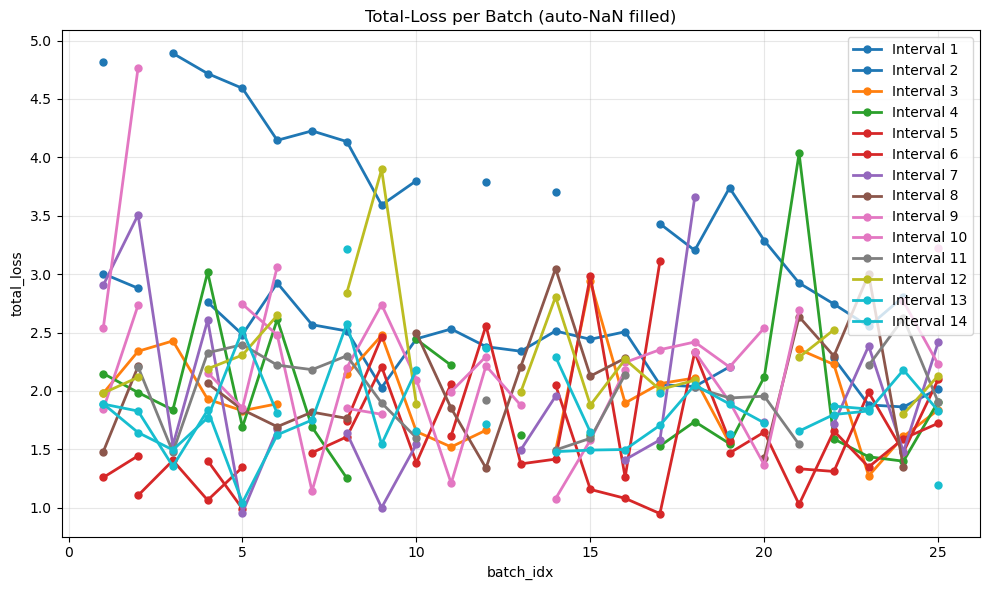

block : {2: 1.9204771518707275, 3: 2.902361869812012, 5: 2.6685070991516118, 6: 3.140872001647949, 7: 2.78603744506836, 8: 4.201169490814209, 9: 2.62772274017334, 11: 2.703964233398437, 12: 3.1370689868927, 13: 2.1871790885925293, 16: 2.568636894226074, 17: 2.1692185401916504, 18: 2.449936866760254, 19: 1.2120530605316162, 21: 3.178048849105835, 22: 2.9129738807678223, 23: 2.511058807373047, 25: 2.71729588508606, 27: 2.8156912326812744, 28: 3.937100887298584, 29: 3.5685863494873047, 30: 2.188419818878174, 32: 2.8173375129699707, 33: 3.7087364196777344, 35: 2.6551098823547363, 37: 2.1841259002685547, 40: 2.786125659942627, 41: 2.3963215351104736, 42: 2.623239040374756, 43: 2.2728254795074463, 44: 2.537596702575684, 45: 2.467897415161133, 46: 2.7474308013916016, 47: 2.784061908721924, 49: 2.266903877258301, 50: 3.111172676086426, 51: 2.5584757328033447, 52: 2.339540481567383, 53: 2.4709227085113525, 54: 1.3075230121612549, 55: 2.7636375427246094, 56: 2.854950428009033, 57: 2.787658691406

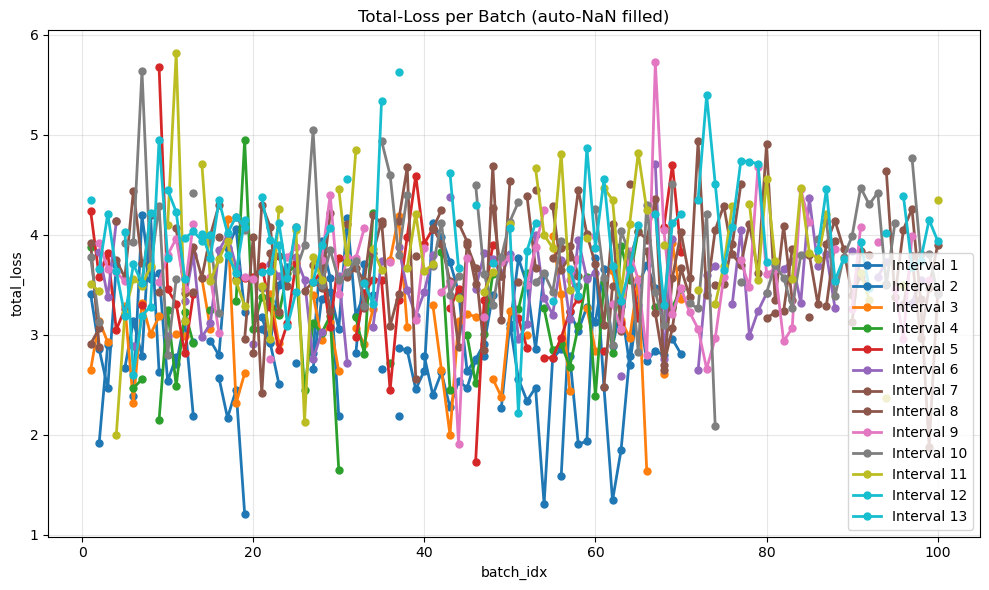

In [7]:
# for interval in intervals:
#     if not interval:  # 跳過空區間
#         continue
filled = fill_nan_dynamic(intervals[:14])
plot_intervals(filled)

filled = fill_nan_dynamic(intervals[15:])
plot_intervals(filled)